# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [1]:
max_edges = 15000 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import export_graphviz
import pydot
from sklearn.ensemble import RandomForestRegressor
from __future__ import division

## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [3]:
lines = []
total_line_count = 0
with open(edges_csv_file, 'rb') as f:
    f.readline()   # skip first line / header
    while True:
        line = f.readline()
        if not line:
            break
        if not (max_edges > 0 and len(lines) >= max_edges):
            lines.append(line)
        total_line_count += 1
G = nx.parse_edgelist(lines, delimiter=',', nodetype=int)

In [4]:
print "Using %d edges out of %d available (%.2f%% of data)" % (len(lines), total_line_count, len(lines)/total_line_count * 100)

Using 15000 edges out of 229338 available (6.54% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [5]:
centrality_measures = {}

#### Degree

In [6]:
centrality_measures["degree"] = nx.degree(G)

#### Eigenvector centrality

In [7]:
centrality_measures["eigenvector_centrality"] = nx.eigenvector_centrality_numpy(G)

####  Approximate betweenness centrality (current flow)

In [8]:
centrality_measures["betweenness_centrality"] = nx.approximate_current_flow_betweenness_centrality(G)

#### Closeness centrality

In [8]:
# Very slow!
centrality_measures["closeness_centrality"] = nx.closeness_centrality(G)

#### Betweenness centrality

In [9]:
# Very slow!
centrality_measures["betweenness_centrality"] = nx.betweenness_centrality(G)

### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [9]:
df = pd.read_csv(nodes_csv_file)

In [10]:
# Add columns to dataframe
def merge_columns(dataframe, data):
    df = dataframe.copy()
    for col in data:
        rows = []
        for item in data[col].items():
            rows.append({"id": item[0], col: item[1]})
        df = df.merge(pd.DataFrame(rows))
    return df

df = merge_columns(df, centrality_measures)

### Let's convert some fields to numeric

In [11]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory'
]

numeric_features = [
    'degree',
    'eigenvector_centrality',
    #'closeness_centrality',
    'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = df.replace("<<MISSING_DATA>>", np.NaN)
df[numeric_features] = df[numeric_features].apply(pd.to_numeric)
df[['price']] = df[['price']].apply(pd.to_numeric)

for feature in numeric_features:
    df[feature].fillna(df[feature].mean(), inplace = True)

### Remove nodes without price and outliers

In [12]:
df = df.drop(df[df["price"].isnull()].index)
df = df.drop(df[df["price"] > 500].index)

### Inspect columns

In [13]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'eigenvector_centrality', u'degree',
       u'betweenness_centrality'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [14]:
df.describe(include='all')

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,...,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
count,3070.000000,3070,3070,3070,3045,3045,0.0,346,2922,2882,...,3070.000000,3070.000000,3070.000000,3070.000000,3070.000000,3070.000000,3070.000000,3.070000e+03,3070.000000,3070.000000
unique,NaN,3014,3070,2319,8,382,NaN,287,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Macroeconomia,https://www.amazon.com.br/dp/9724418553/,Vários Autores (Autor),Capa comum,Companhia das Letras,NaN,1 de janeiro de 2014,Livros,Livros,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5,1,33,2629,192,NaN,5,2922,2882,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2465.511075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,368.999853,13.951694,4.469695,15.464900,22.448944,2.147453,441.911335,4.059117e-03,7.702606,0.002551
std,2176.371452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,243.904988,34.035873,0.534578,2.570196,2.584363,1.202483,205.124700,1.587279e-02,17.326353,0.008098
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.000000,1.000000,1.000000,2.600000,10.000000,0.200000,18.100000,5.842757e-08,1.000000,0.000000
25%,896.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,209.250000,2.000000,4.473275,13.800000,20.800000,1.400000,299.000000,4.509963e-06,1.000000,0.000000
50%,2100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,316.000000,9.000000,4.473275,15.500000,22.800000,2.000000,449.233179,1.322924e-05,2.000000,0.000164
75%,3215.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,456.000000,13.873001,4.900000,16.200000,23.400000,2.600000,544.000000,1.293926e-04,5.000000,0.001708


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [15]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,...,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,...,68.0,1.000000,4.000000,14.0,21.0,0.6,181.0,0.012593,19,0.005734
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,...,352.0,3.000000,4.600000,14.6,21.0,1.9,363.0,0.053497,62,0.002665
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,160.0,13.873001,4.473275,14.4,20.8,0.8,200.0,0.034535,59,0.009335
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,320.0,2.000000,4.500000,13.7,21.5,1.6,381.0,0.011868,18,0.006475
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,848.0,4.000000,4.500000,13.8,21.8,4.0,939.0,0.074795,88,0.014521
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,418.0,1.000000,5.000000,13.8,21.5,2.2,581.0,0.050004,43,0.009172
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,...,160.0,13.873001,4.473275,13.7,21.5,0.8,159.0,0.008733,9,0.000559
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,...,160.0,2.000000,5.000000,13.8,21.6,1.0,159.0,0.004537,10,0.008173
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,...,480.0,13.873001,4.473275,13.6,20.3,2.3,522.0,0.019512,23,0.002438
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/0486661016/,"Erwin Schrodinger (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,...,112.0,13.873001,4.473275,14.0,20.3,1.3,159.0,0.007206,15,0.005378


## Random forest using degree as feature, price as target

### Preparing data

In [16]:
df_with_dummies = pd.get_dummies(df[numeric_features + categorical_features + ['price']],columns=categorical_features,drop_first=True)

In [17]:
feature_list = list(df_with_dummies.drop(columns = ['price']))
features = np.array(df_with_dummies.drop(columns = ['price']))
target = np.array(df_with_dummies['price'])

### Average price as baseline

It's important to have a baseline, so we can validate our predictions after running our model. One easy choice for baseline is the average price of a book.

We have an average price around R\$43, so this means that a very easy prediction would be to always guess R$43 for the price of any book.

In [18]:
average_target = np.average(target)
print "Average price: R$", average_target

Average price: R$ 68.1872247557


### Training data split

Let's split our dataset into two sets: train and test. We use the first to train or model, and we use the second to test the precision of our model.

In [19]:
# Split the data into training and testing sets
train_features, test_features, train_target, test_target \
    = train_test_split(features, target, test_size = 0.25)

# Summary
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_target.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_target.shape)

('Training Features Shape:', (2302, 1061))
('Training Labels Shape:', (2302,))
('Testing Features Shape:', (768, 1061))
('Testing Labels Shape:', (768,))


### Train data

We train a random forest model with 500 estimators.

In [20]:
# Load model
rf = RandomForestRegressor(n_estimators = 500)
# Train
rf.fit(train_features, train_target);

### Prediction

In [21]:
predictions = rf.predict(test_features)

####  List of most important features

In [22]:
importance = zip(feature_list, rf.feature_importances_)
importance.sort(key=lambda x:-x[1])
pd.DataFrame(importance).head(200)

,0,1
0,height,0.199991
1,width,0.174737
2,eigenvector_centrality,0.160988
3,pages,0.096946
4,publisher_Springer,0.043352
5,weight,0.037413
6,publisher_Cambridge University Press,0.033184
7,ranking,0.030764
8,depth,0.030068
9,language_Inglês,0.018333


####  Preço previsto vs. Preço real

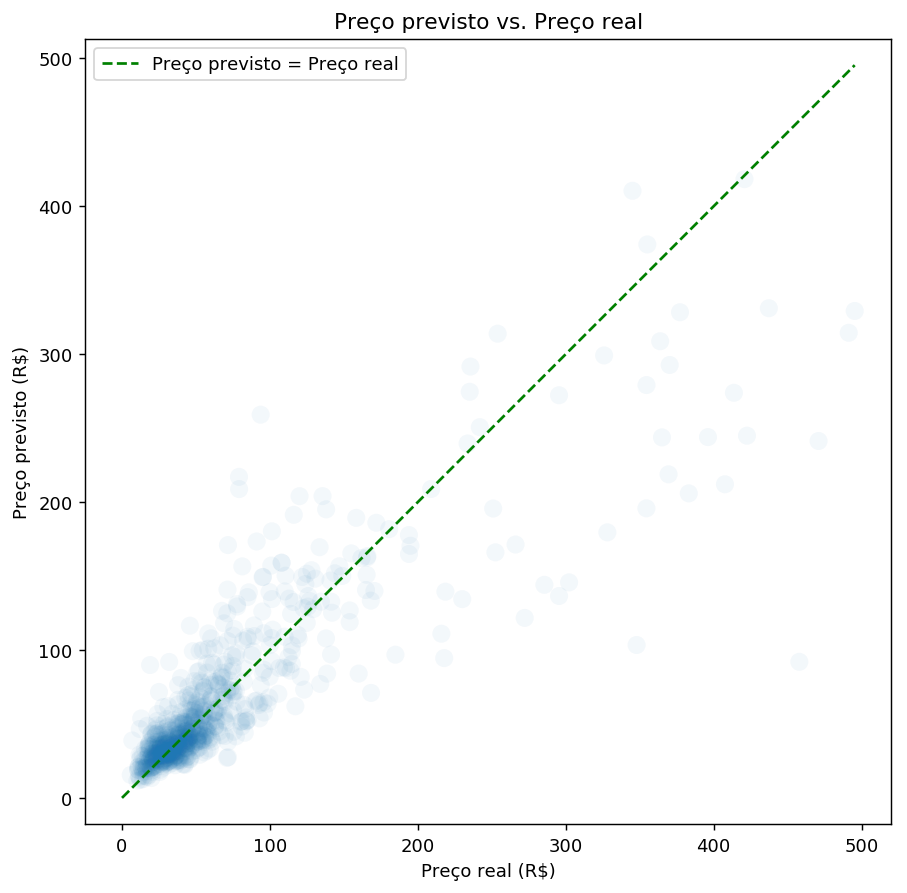

In [23]:
plt.figure(figsize=(8,8), dpi=130)
plt.scatter(test_target, predictions, 100, alpha=0.05, edgecolors="none")
baseline = [0, np.max(test_target)]
plt.plot(baseline, baseline, "--", color="green", label = u"Preço previsto = Preço real")
ax = plt.gca()
ax.set_ylabel(u"Preço previsto (R$)")
ax.set_xlabel(u"Preço real (R$)")
ax.legend()
plt.title(u"Preço previsto vs. Preço real")
plt.axes().set_aspect('equal', 'datalim')
#plt.xlim(0, 150)
#plt.ylim(0, 150)
plt.show()

### Mean absolute error

Now we can compare the errors obtained by our predictions against the errors provided by the baseline (average price). Our prediction errors should be less than the baseline errors to consider the model successful.

In [24]:
# Calculate the absolute errors
errors = abs(predictions - test_target)
errors_baseline = abs(average_target - test_target)
# Print out the mean absolute error (mae)
print('Mean absolute prediction error: R$', round(np.mean(errors), 2))
print('Mean absolute error using average: R$',
      round(np.mean(errors_baseline), 2))

('Mean absolute prediction error: R$', 19.4)
('Mean absolute error using average: R$', 44.6)


### Worst predictions

Below we can inspect the rows with the biggest prediction error.

In [25]:
data = {
    "degree": test_features.tolist(),
    "target": test_target,
    "prediction": predictions,
    "error": errors,
    "errors_baseline": errors_baseline
}
predicted_df = pd.DataFrame(data = data)
predicted_df.sort_values('error', ascending = False).head(10)

,degree,error,errors_baseline,prediction,target
655,"[78.0, 0.0857558887756, 0.00662960589608, 4416...",365.87326,389.662775,91.97674,457.85
654,"[1.0, 0.00191994637408, 0.0, 128507.0, 13.8730...",244.51168,279.672775,103.34832,347.86
442,"[32.0, 0.0696851503013, 0.00176132246306, 3583...",229.62524,402.682775,241.24476,470.87
130,"[33.0, 0.070319621365, 0.00185685271901, 44166...",195.58934,339.402775,212.00066,407.59
332,"[27.0, 0.0608766019643, 0.00119946950387, 4416...",177.63610,354.282775,244.83390,422.47
614,"[8.0, 0.0185953466597, 0.000296601348954, 4416...",177.29850,314.952775,205.84150,383.14
231,"[116.0, 0.115255912433, 0.00861388601227, 2321...",176.85914,423.072775,314.40086,491.26
289,"[53.0, 0.0643325293893, 0.00669490871705, 1091...",166.15074,427.112775,329.14926,495.30
336,"[30.0, 0.0580169156872, 0.00127766898951, 8185...",165.32188,25.542775,259.05188,93.73
477,"[6.0, 0.00713253353327, 0.000499584978784, 441...",158.95144,227.252775,136.48856,295.44


### Best predictions

In [26]:
predicted_df.sort_values('error', ascending = True).head(10)

,degree,error,errors_baseline,prediction,target
105,"[1.0, 4.50996325025e-06, 0.0, 24854.0, 13.8730...",0.03714,41.887225,26.33714,26.30
250,"[3.0, 0.00212975246107, 0.000542460052846, 125...",0.04124,2.902775,71.13124,71.09
706,"[2.0, 7.78109476584e-06, 0.00380866529846, 172...",0.06090,4.812775,73.06090,73.00
589,"[2.0, 2.63437878382e-05, 0.000246143003173, 14...",0.06930,39.157225,28.96070,29.03
660,"[18.0, 9.37342571194e-05, 0.00236472965863, 34...",0.13220,46.997225,21.05780,21.19
89,"[7.0, 2.32386077996e-05, 0.00155887334628, 839...",0.14138,47.287225,21.04138,20.90
737,"[3.0, 0.00283964857464, 0.00285218962654, 1302...",0.14974,19.237225,48.80026,48.95
557,"[5.0, 7.66966176255e-05, 0.00278855656408, 412...",0.17578,15.567225,52.79578,52.62
118,"[2.0, 2.7167135419e-05, 0.000267853077182, 866...",0.18010,140.812775,208.81990,209.00
465,"[1.0, 4.7988237127e-06, 0.0, 2021.0, 15.0, 856...",0.20658,93.682775,162.07658,161.87


In [27]:
predicted_df.describe()

,error,errors_baseline,prediction,target
count,768.000000,768.000000,768.000000,768.000000
mean,19.402931,44.596121,65.426856,67.270833
std,32.381932,58.430644,58.047174,73.516708
min,0.037140,0.287225,11.611060,5.900000
25%,4.309765,19.287225,31.685765,29.900000
50%,9.413550,32.540000,43.078050,44.145000
75%,19.527465,45.412225,74.719440,70.040000
max,365.873260,427.112775,418.264120,495.300000


### Visualize decision tree

In [28]:
# Pull out one tree from the forest
tree = rf.estimators_[0]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot',
                feature_names = feature_list, rounded = True)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

<img src="files/image.png">